Goals: \
Predict throughput (speed) \
Predict RTT (ping / latency) \
Predict lossrate 

Sql query used to get data:

SELECT
  client.Geo.Latitude AS Lat, \
  client.Geo.Longitude AS Long, \
  client.Geo.City AS City,\
  client.Geo.PostalCode AS PostalCode,\
  client.Geo.AccuracyRadiusKm AS Accuracy,\
  client.Geo.CountryCode, \
  a.MeanThroughputMbps AS Mbps,\
  raw.StartTime AS StartTime,\
  raw.EndTime AS Endtime,\
  a.*\
FROM\
  `measurement-lab.ndt.ndt7`\
WHERE\
  date BETWEEN "2017-04-11"\
  AND "2022-04-11"\
  AND client.Geo.CountryCode = "NO"\
  AND client.Geo.AccuracyRadiusKm <= 5\
  --AND a.CongestionControl = "cubic"\
  --AND a.CongestionControl = "bbr"\
ORDER BY Endtime asc 



Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from matplotlib import colors
import plotly.graph_objects as go
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
#import mglearn
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import *
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression , LinearRegression, TweedieRegressor, SGDRegressor, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
import feather
import os

Reading CSV and converting it to Feather format, if it exsists, otherwise read the Feather format

In [17]:
path = 'testdata.csv'
if os.path.exists(path):
    names = ['Lat', 'Long', 'City', 'PostalCode', 'Accuracy',	'CountryCode', 'Mbps',	'StartTime',
         'Endtime', 'UUID', 'TestTime',	'CongestionControl', 'MeanThroughputMbps',	'MinRTT', 'LossRate']
    dataFrame = pd.read_csv('testdata.csv', sep=',', nrows=1_000_000, names=names)

    print('File exists')
else:
    dataFrame = feather.read_dataframe('testdata.feather')
        
    print('File does not exist')


feather.write_dataframe(dataFrame, 'testdata.feather')

dataFrame = feather.read_dataframe('testdata.feather')

File exists


In [4]:
print (dataFrame.head())
print (dataFrame.shape)

       Lat     Long    City  PostalCode  Accuracy CountryCode       Mbps  \
0  63.2900  10.2707  Melhus      7224.0         5          NO  68.159229   
1  63.2900  10.2707  Melhus      7224.0         5          NO  76.744481   
2  63.3768  10.3923  Tiller      7075.0         1          NO   8.088556   
3  63.3768  10.3923  Tiller      7075.0         1          NO  27.124351   
4  63.3768  10.3923  Tiller      7075.0         1          NO   8.266963   

                        StartTime                         Endtime  \
0  2020-05-17 20:08:11.283101 UTC  2020-05-17 20:08:21.299873 UTC   
1  2020-05-17 20:08:21.395899 UTC  2020-05-17 20:08:31.464652 UTC   
2  2020-05-27 10:34:20.960903 UTC  2020-05-27 10:34:31.194652 UTC   
3  2020-05-27 10:34:10.488327 UTC  2020-05-27 10:37:59.533387 UTC   
4  2020-05-27 10:41:18.545301 UTC  2020-05-27 10:41:28.755947 UTC   

                                    UUID                        TestTime  \
0  ndt-t4mj4_1589315185_000000000002DBB9  2020-05-17

New dataset with only the columns we want, and only the rows we want

In [5]:
newDataFrame = dataFrame[['MinRTT', 'Mbps']]
newDataFrame = newDataFrame[newDataFrame['MinRTT'] < 1000]
newDataFrame = newDataFrame[newDataFrame['Mbps'] < 1000]

newDataFrame = newDataFrame[newDataFrame['MinRTT'] > 0]
newDataFrame = newDataFrame[newDataFrame['Mbps'] > 5]

Show 10 largest and 10 smallest values

In [6]:
# Print the 10 highest values
print(newDataFrame.nlargest(10, 'MinRTT'))

# Print the 10 lowest values
print(newDataFrame.nsmallest(10, 'MinRTT'))

         MinRTT       Mbps
594293  755.596   6.047078
129666  645.882   6.141626
572622  637.614   5.852613
617598  611.710   9.698824
670635  569.387   5.968112
988860  566.696   5.329417
734997  561.994   7.265100
294793  533.140   7.111650
129258  518.634  10.485073
840607  513.241   7.221992
         MinRTT        Mbps
610328    0.284  515.552886
923042    0.286  506.640531
1045925   0.316   80.650714
882896    0.321  491.401198
929762    0.322  239.108586
732128    0.323  928.859577
929761    0.323  868.057288
1045924   0.325   73.087529
319186    0.327  363.698181
559160    0.331  428.737590


In [7]:
X = newDataFrame['Mbps'].values.reshape(-1, 1)
y = newDataFrame['MinRTT']

Make train and test sets

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Linear Regression / Polynomial Regression

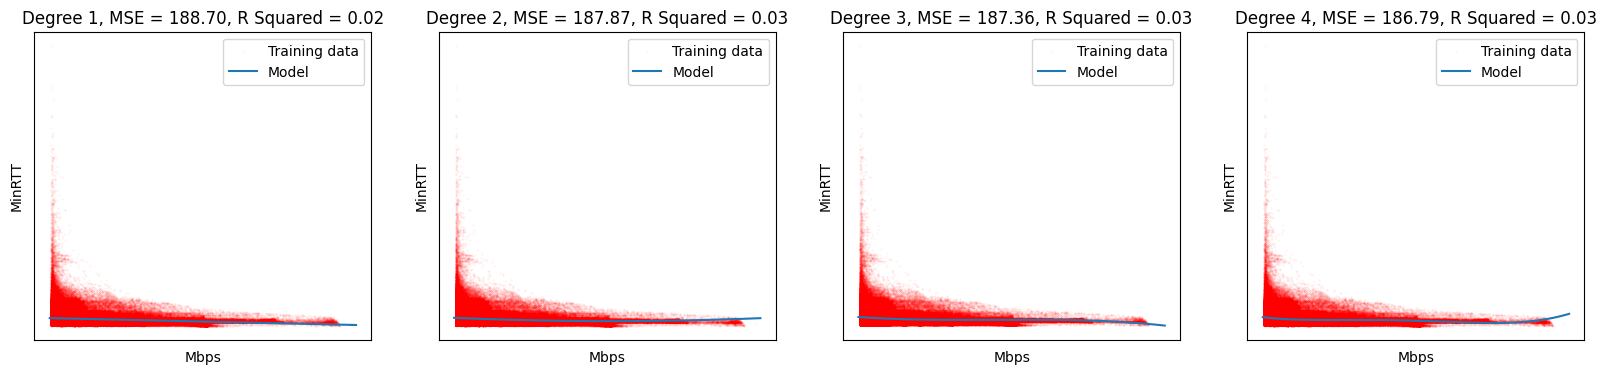

In [9]:
degrees = [i for i in range(1, 5)]


plt.figure(figsize=(20, 4))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    poly_features = PolynomialFeatures(
        degree=degrees[i], include_bias=False, interaction_only=False)
    X_poly = poly_features.fit_transform(X)

    linear_reg = LinearRegression()

    linear_reg.fit(X_poly, y)
    linear_reg.set_params()

    X_vals = np.linspace(0, 1000, 1_400_000).reshape(-1, 1)
    X_vals_poly = poly_features.transform(X_vals)

    y_vals = linear_reg.predict(X_vals_poly)

    # Evaluate the model
    y_pred = linear_reg.predict(X_poly)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    plt.scatter(X, y, s=0.1, alpha=0.1,
                color='red', label="Training data")
    plt.plot(X_vals, y_vals, label="Model")
    plt.xlabel("Mbps")
    plt.ylabel("MinRTT")
    plt.legend(loc="upper right")
    plt.title("Degree {}, MSE = {:.2f}, R Squared = {:.2f}".format(
        degrees[i], mse, r2))
plt.show()


Use Mpbs to predict if Lat and Long are in city

In [10]:
# Mpbs, Lat, Long
x = dataFrame.iloc[:, [6,13,14]]
# City
y = dataFrame.iloc[:,2]
y = y.to_frame()
y = y.notnull().astype('int')
y = y.values.ravel()

print (x)
print ("\n")
print (y.shape)

               Mbps  MinRTT  LossRate
0         68.159229  15.857  0.000000
1         76.744481  16.194  0.000000
2          8.088556  23.036  0.000000
3         27.124351  21.898  0.000000
4          8.266963  20.000  0.000000
...             ...     ...       ...
1048570   14.129729  18.606  0.000021
1048571  234.351104  15.897  0.000000
1048572  164.885260  15.636  0.000000
1048573   41.368126  18.912  0.000042
1048574   29.927483  14.150  0.000000

[1048575 rows x 3 columns]


(1048575,)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print(classification_report(y_test, y_pred))

ZeroDivisionError = confusion_matrix(y_test, y_pred)
print(ZeroDivisionError)

              precision    recall  f1-score   support

           0       0.50      0.00      0.00      4021
           1       0.99      1.00      0.99    310552

    accuracy                           0.99    314573
   macro avg       0.74      0.50      0.50    314573
weighted avg       0.98      0.99      0.98    314573

[[     2   4019]
 [     2 310550]]


Generate Map

In [14]:
# Get Mbps, Longitude and Latitude from the dataframe
dataFrame = dataFrame[['Mbps', 'Long', 'Lat']]
# Make Mbps, Longitude and Latitude into X, Y and Z
z_Mbps = dataFrame['Mbps']
x_long = dataFrame['Long'].values.reshape(-1, 1)
y_lat = dataFrame['Lat'].values.reshape(-1, 1)


x_long.astype(float)
y.astype(float)
z_Mbps.astype(float)

X = np.array(list(zip(x_long, y_lat))).reshape(len(x_long), 2)
kmeans = KMeans(n_clusters=800).fit(X, sample_weight=z_Mbps)
centroids = kmeans.cluster_centers_

#create heatmap
map = folium.Map(location=[60.4720, 8.4689], zoom_start=5)
map.add_child(plugins.HeatMap([[centroids[i][1], centroids[i][0]] for i in range(len(centroids))], radius=20))
map.save('map.html')

In [12]:
# Get Lossrate MinRTT and Mbps from the dataframe
dataFrame = dataFrame[['LossRate', 'MinRTT', 'Mbps']]
# Make LossRate, MinRTT and Mbps into X, Y and Z
X = dataFrame['LossRate'].values.reshape(-1, 1)
Y = dataFrame['MinRTT'].values.reshape(-1, 1)
Z = dataFrame['Mbps'].values.reshape(-1, 1)


# Remove outliers
X = X[X < 1000]
Y = Y[Y < 1000]
Z = Z[Z < 1000]

# Remove negative values
X = X[X > 0]
Y = Y[Y > 0]
Z = Z[Z > 0]

# Exagurate LossRate 
X = X * 100

# Combine Y and Z into one array
data_yz = np.array([Y, Z]).reshape(-1, 1)

# Polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# Linear regression
model = LinearRegression()
model.fit(X_poly, data_yz)
y_poly_pred = model.predict(X_poly)

# Evaluate the model
mse = mean_squared_error(data_yz, y_poly_pred)
r2 = r2_score(data_yz, y_poly_pred)



C:\Users\01sti\AppData\Local\Temp\ipykernel_109924\1616173250.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_yz = np.array([Y, Z]).reshape(-1, 1)


ValueError: Expected 2D array, got 1D array instead:
array=[0.33544343 0.20096522 0.01550284 ... 0.81024851 0.00213535 0.00415506].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Create a 3D plot
fig = go.Figure(data=[go.Scatter3d(
    x=X_test['LossRate'],
    y=X_test['Mbps'],
    z=y_test,
    mode='markers',
    marker=dict(
        size=1,
        color=y_test,
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Add a regression plane
fig.add_trace(go.Surface(
    x=X_test['LossRate'],
    y=X_test['Mbps'],
    z=y_pred,
    opacity=1,
    showscale=False
))

# Update the layout
fig.update_layout(
    title='MinRTT',
    scene=dict(
        xaxis_title='LossRate',
        yaxis_title='Mbps',
        zaxis_title='MinRTT'
    ),
    width=700,
    margin=dict(r=20, b=10, l=10, t=10)
)

# Show the plot
fig.show()



In [ ]:
# Show lowest values
print(X.nsmallest(10, 'LossRate'))

# Show highest values
print(X.nlargest(10, 'LossRate'))



AttributeError: 'numpy.ndarray' object has no attribute 'nsmallest'